In [1]:
# Libraries
import math
import cv2
import sys
import os
import numpy as np
import random
from matplotlib import pyplot as plt
from IPython.display import clear_output
%matplotlib inline

In [2]:
'''
USYD CODE CITATION ACKNOWLEDGEMENT:
The majority of the following code has been provided by the COMP3419 staff.
'''
# helper function to draw arrows
def arrowdraw(img, x1, y1, x2, y2):
    radians = math.atan2(x1-x2, y2-y1)
    x11 = 0
    y11 = 0
    x12 = -10
    y12 = -10

    u11 = 0
    v11 = 0
    u12 = 10
    v12 = -10
    
    x11_ = x11*math.cos(radians) - y11*math.sin(radians) + x2
    y11_ = x11*math.sin(radians) + y11*math.cos(radians) + y2

    x12_ = x12 * math.cos(radians) - y12 * math.sin(radians) + x2
    y12_ = x12 * math.sin(radians) + y12 * math.cos(radians) + y2
    
    u11_ = u11 * math.cos(radians) - v11 * math.sin(radians) + x2
    v11_ = u11 * math.sin(radians) + v11 * math.cos(radians) + y2

    u12_ = u12 * math.cos(radians) - v12 * math.sin(radians) + x2
    v12_ = u12 * math.sin(radians) + v12 * math.cos(radians) + y2
    img = cv2.line(img, (x1, y1), (x2, y2), (255, 255, 255), 1)
    img = cv2.line(img, (int(x11_), int(y11_)), (int(x12_), int(y12_)), 
    (255, 255, 255), 1)
    img = cv2.line(img, (int(u11_), int(v11_)), (int(u12_), int(v12_)), 
    (255, 255, 255), 1)
    
    return img

In [3]:
'''
USYD CODE CITATION ACKNOWLEDGEMENT:
The majority of the following code has been provided by the COMP3419 staff.
'''

# Extract frames from monkey video

if not os.path.isdir(os.path.join(os.getcwd(), 'frames')):
    os.mkdir("frames")
else:
    print('frames already exists')

if not os.path.isdir(os.path.join(os.getcwd(), 'composite')):
    os.mkdir("composite")
else:
    print('composite already exists')
    
framenumber = 0 # 751 frames total
framectr = 0
movie_path = 'monkey.avi'
omovie = cv2.VideoCapture(movie_path)
frame_height = omovie.get(cv2.CAP_PROP_FRAME_HEIGHT)
frame_width = omovie.get(cv2.CAP_PROP_FRAME_WIDTH)

while(1):
    ret, frame = omovie.read()
    if not ret:
        break
    print('Extracting: %d' % framenumber)
    clear_output(wait=True)
    cv2.imwrite('frames/%d.tif' % framenumber, frame)
    framenumber += 1
omovie.release()

Extracting: 751


In [34]:
# returns top-left coordinate of a valid destination block
def minSSD(x, y, grid_sz, cur_frame, next_frame, threshold_range, N):
  min_dist = float('inf')
  index = -1
  grid = cur_frame[x:x+grid_sz, y:y+grid_sz, :] # (9, 9, 3)
  x_pos = [x-grid_sz, x, x+grid_sz]
  y_pos = [y-grid_sz, y, y+grid_sz]
  grid_dest = [] 
  
  # get neighbouring grids
  for i in range(N):
    sz = int(np.sqrt(N))
    X = x_pos[i % sz]
    Y = y_pos[i // sz]
    grid_dest.append(next_frame[X:X+grid_sz, Y:Y+grid_sz, :])
  
  # find min dist
  for i in range(len(grid_dest)):
    grid_prime = grid_dest[i]
    squared_dist = np.sum((grid-grid_prime)**2)
    dist = np.sqrt(squared_dist)
    if dist < min_dist:
      min_dist = dist
      index = i

  # determine whether min dist is within threshold
  if min_dist <= threshold_range[1] and min_dist >= threshold_range[0]:
    target = (x_pos[index % 3], y_pos[index // 3])
    return target
  
  return (-1, -1)

In [60]:
# function to write frame for hyperparam tuning

def write_frame(k, threshold_range, N, process_frame, framectr, id):
  grid_sz = 2*k+1
  pos_offset = grid_sz 
  cur_frame = cv2.imread('frames/%d.tif' % process_frame)
  next_frame = cv2.imread('frames/%d.tif' % (process_frame+1))
  combined_img = cur_frame.copy() 
  print('Processing frame: %d, overall progress: %.2f %%' % (process_frame, process_frame/framectr*100))
  clear_output(wait=True)
  # x,y is top left of grid
  for y in range(pos_offset, cur_frame.shape[1] - pos_offset, grid_sz):
    for x in range(pos_offset, cur_frame.shape[0] - pos_offset, grid_sz):
      # get centre coordinates of current grid
      x1 = x+k
      y1 = y+k
      (b, g, r) = cur_frame[x1, y1]
      # filter out blue macroblocks
      if b < BLUE:
        target = minSSD(x, y, grid_sz, cur_frame, next_frame, threshold_range, N)
        if target != (-1, -1):
          # get centre coordinates of target grid
          x2 = target[0] + k
          y2 = target[1] + k
          combined_img = arrowdraw(combined_img, y1, x1, y2, x1)
  # text: 
  text = 'k = {}, threshold = {}, neighbour blocks = {}'.format(k, threshold_range, N-1)
  cv2.putText(combined_img, text=text, org=(100, 100),
              fontFace=cv2.FONT_HERSHEY_DUPLEX, fontScale=0.5, thickness = 1, 
              color=(0, 255, 0))             
  cv2.imwrite('composite/composite_new%d.tif' % id, combined_img)
  
  cv2_imshow(combined_img)

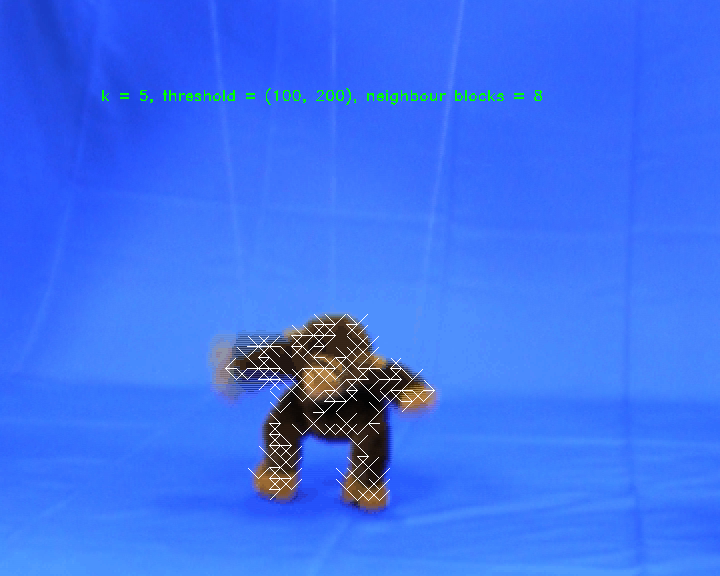

In [61]:
# HYPERPARAM TUNING

from google.colab.patches import cv2_imshow

framenumber = 2
framectr = framenumber - 1
process_frame = 0
k_list = [3,4,5]

BLUE = 120
threshold_range_list = [(10, 100), (150, 200), (100, 200)]
N_list = [1,4,9]
id = 0
while process_frame < framectr:
  for k in k_list:
    write_frame(k, threshold_range_list[-1], N_list[-1], process_frame, framectr, id)
    id += 1
  for threshold_range in threshold_range_list:
    write_frame(k_list[2], threshold_range, N_list[-1], process_frame, framectr, id)
    id += 1
  for N in N_list:
    write_frame(k_list[2], threshold_range_list[-1], N, process_frame, framectr, id)
    id += 1
  if cv2.waitKey(30) & 0xff == ord('q'):
      break
  process_frame += 1

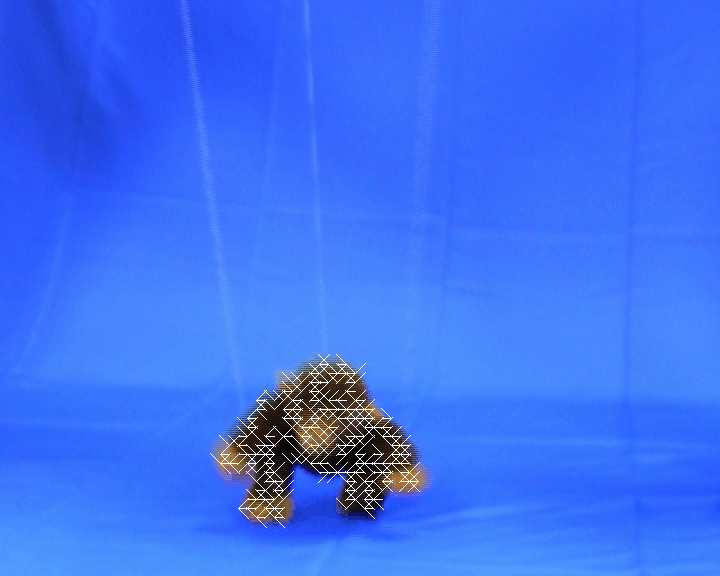

In [62]:
# make composite frames for actual video

framenumber = 376
framectr = framenumber - 1
process_frame = 0
k = 4
grid_sz = 2*k+1
pos_offset = grid_sz
BLUE = 120
threshold_range = (100, 200)
N = 9

# iterate through each frame
while process_frame < framectr:
    # retrieve current and next frame
    cur_frame = cv2.imread('frames/%d.tif' % process_frame)
    next_frame = cv2.imread('frames/%d.tif' % (process_frame+1))
    combined_img = cur_frame.copy() 
    print('Processing frame: %d, overall progress: %.2f %%' % (process_frame, process_frame/framectr*100))
    clear_output(wait=True)
    
    # iterate through each macroblock
    for y in range(pos_offset, cur_frame.shape[1] - pos_offset, grid_sz):
      for x in range(pos_offset, cur_frame.shape[0] - pos_offset, grid_sz):
        # get centre coordinates of current grid
        x1 = x+k
        y1 = y+k
        (b, g, r) = cur_frame[x1, y1]
        # filter out blue macroblocks
        if b < BLUE:
          target = minSSD(x, y, grid_sz, cur_frame, next_frame, threshold_range, N)
          if target != (-1, -1):
            # get centre coordinates of target grid
            x2 = target[0] + k
            y2 = target[1] + k
            combined_img = arrowdraw(combined_img, y1, x1, y2, x1)
    
    # write and display the final image              
    cv2.imwrite('composite/composite%d.tif' % process_frame, combined_img)
    cv2_imshow(combined_img)
    if cv2.waitKey(30) & 0xff == ord('q'):
        break
    process_frame += 1

In [ ]:
'''
USYD CODE CITATION ACKNOWLEDGEMENT:
The majority of the following code has been provided by the COMP3419 staff.
'''
count = 0
output_video = 'Ass1a.mp4'

out = cv2.VideoWriter(output_video, cv2.VideoWriter_fourcc('M', 'J', 'P', 'G'), 25, (int(frame_width), int(frame_height)))
while(1):
    img = cv2.imread('composite/composite_new%d.tif' % count)
    if img is None:
        print('No more frames to be loaded')
        break
    clear_output(wait=True)
    for i in range(25):
      out.write(img)  
    count += 1
    print('Saving video: %d%%' % int(100*count/framenumber))

count = 0
while(1):
    img = cv2.imread('composite/composite%d.tif' % count)
    if img is None:
        print('No more frames to be loaded')
        break
    clear_output(wait=True)
    out.write(img)
    count += 1
    print('Saving video: %d%%' % int(100*count/framenumber))
    
out.release()
cv2.destroyAllWindows()

In [ ]:
'''
USYD CODE CITATION ACKNOWLEDGEMENT:
The following code has been provided by the COMP3419 staff.
'''
# Capture Video and represent it as a object
path_to_video =  output_video
cap = cv2.VideoCapture(path_to_video)
# Check whether video is captured correctly by cv2
if not cap.isOpened():
    print('{} not opened'.format(path_to_video))
    sys.exit(1)
# Use cv2 to fetch three important variables
time_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
frame_width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
# Use for loop to have access to video frame by frame
while(1):
    clear_output(wait=True)
    return_flag, frame = cap.read()  
    if not return_flag:
        print('Video Reach End')
        break

    cv2_imshow(frame)
    if cv2.waitKey(30) & 0xff == ord('q'):
        break
# Securely release video and close windows
cap.release()
cv2.destroyAllWindows()